In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime

### Reading the csv files

In [32]:
msp_data = pd.read_csv("CMO_MSP_Mandi.csv")
msp_data = msp_data.rename(columns = {'Type' : 'type'})
apmc_data = pd.read_csv("Monthly_data_cmo.csv")
apmc_data = apmc_data.rename(columns = {'APMC' : 'apmc', 'Commodity' : 'commodity', 'Year' :'year','Month' : 'month' })

Making some data adjustments for smooth trend comparison and chart plotting

In [33]:
apmc_data['monthnum'] = apmc_data.month.apply(lambda x: datetime.strptime(x, '%B').strftime('%m')).astype(int)
apmc_data.commodity = apmc_data.commodity.apply(lambda x: x.lower())
msp_data.loc[(msp_data.commodity == 'SUGAR-CANE') | (msp_data.commodity == 'SUGARCANE'), 'commodity'] = 'SUGARCANE'
msp_data.commodity = msp_data.commodity.apply(lambda x: x.lower())

In [34]:
#counting the number of commodities whose msprice is available
len(msp_data.drop_duplicates(['commodity']).merge(apmc_data.drop_duplicates(['commodity']), on = 'commodity', how = 'inner')[['commodity']])

19

### Data Exploration

In [35]:
apmc_data.dtypes

apmc               object
commodity          object
year                int64
month              object
arrivals_in_qtl     int64
min_price           int64
max_price           int64
modal_price         int64
date               object
district_name      object
state_name         object
monthnum            int64
dtype: object

In [36]:
msp_data.head()

,commodity,year,type,msprice,msp_filter
0,paddy-unhusked,2012,Kharif Crops,1250.0,1
1,rice(paddy-hus),2012,Kharif Crops,1280.0,1
2,jowar_hybrid,2012,Kharif Crops,1500.0,1
3,sorgum(jawar),2012,Kharif Crops,1520.0,1
4,bajri,2012,Kharif Crops,1175.0,1


In [37]:
apmc_data.describe()

,year,arrivals_in_qtl,min_price,max_price,modal_price,monthnum
count,62429.000000,6.242900e+04,6.242900e+04,6.242900e+04,62429.000000,62429.000000
mean,2015.337503,6.043088e+03,2.945228e+03,3.688814e+03,3296.003989,6.891317
std,0.690451,3.470331e+04,1.318396e+04,7.662962e+03,3607.792534,3.474213
min,2014.000000,1.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000
25%,2015.000000,3.800000e+01,1.250000e+03,1.600000e+03,1450.000000,4.000000
50%,2015.000000,2.110000e+02,1.976000e+03,2.797000e+03,2425.000000,7.000000
75%,2016.000000,1.364000e+03,3.900000e+03,4.647000e+03,4257.000000,10.000000
max,2016.000000,1.450254e+06,3.153038e+06,1.600090e+06,142344.000000,12.000000


* This shows apmc_data:
 - Has no missing values 
 - Year is ranging from 2014 to 2016

In [38]:
msp_data.describe()

,year,msprice,msp_filter
count,155.000000,145.000000,155.0
mean,2014.000000,2822.448276,1.0
std,1.418798,1441.725928,0.0
min,2012.000000,170.000000,1.0
25%,2013.000000,1470.000000,1.0
50%,2014.000000,2970.000000,1.0
75%,2015.000000,4000.000000,1.0
max,2016.000000,6240.000000,1.0


* Shows that MSP data:  
    - is available for a time period of 2012 to 2016
    - MSPrices column has 10 missing values

### Treatment of Missing Values
- We can replace a missing value with median or mean, Let's check which one is a better representative of the msprice column
- We will also have to check which commodity has missing values and replace it with that commodity's median/mean only

In [39]:
# Lets start with msp_data
def count_missing_values(x):
    return sum(x.isnull())
msp_data.apply(count_missing_values, axis =0)

commodity      0
year           0
type           0
msprice       10
msp_filter     0
dtype: int64

In [40]:
msp_data[msp_data.msprice.isnull() == True ].isnull().groupby([msp_data['commodity'],msp_data['year']])['msprice'].sum().astype(int)

commodity        year
barli            2016    1
gram_yellow      2016    1
masur_yellow     2016    1
mustard          2016    1
safflower        2016    1
soyabean_black   2015    1
                 2016    1
toria_yellow     2016    1
wheat(husked)    2016    1
wheat(unhusked)  2016    1
Name: msprice, dtype: int64

* Above results states that:
    - Total 10 values are missing from msprice column
    - Missing values are for different commodities
    - Mostly in year 2016, so rather than taking median here, we should use msprice of 2015 as a proxy for year 2016
    - For 'Soyabean_Black', we can use 2014 value

In [41]:
dict_msprice_median = msp_data[(msp_data.year == 2015) & (msp_data.commodity != 'soyabean_black')].groupby(['commodity'])['msprice'].median().to_dict()
dict_msprice_median['soyabean_black'] = msp_data[(msp_data.year == 2014) & (msp_data.commodity == 'soyabean_black')].msprice.tolist()[0]

Lets create a dictionary with only the commodities which have missing values in the data

In [42]:
dict_nullmsprice_median = {}
for key in dict_msprice_median:
    if key in msp_data[msp_data.msprice.isna() == True].commodity.unique().tolist():
        dict_nullmsprice_median[key] = dict_msprice_median[key]
dict_nullmsprice_median        

{'barli': 1225.0,
 'gram_yellow': 3425.0,
 'masur_yellow': 3325.0,
 'mustard': 3350.0,
 'safflower': 3300.0,
 'soyabean_black': 2500.0,
 'toria_yellow': 3290.0,
 'wheat(husked)': 1525.0,
 'wheat(unhusked)': 1525.0}

In [43]:
for key in dict_nullmsprice_median:
    msp_data[(msp_data.commodity == key) & (msp_data.msprice.isnull() == True)] = msp_data[(msp_data.commodity == key) & (msp_data.msprice.isnull() == True)].fillna(dict_nullmsprice_median[key])

In [44]:
msp_data.apply(count_missing_values)

commodity     0
year          0
type          0
msprice       0
msp_filter    0
dtype: int64

apmc_data missing values treatment

In [45]:
apmc_data.apply(count_missing_values)

apmc               0
commodity          0
year               0
month              0
arrivals_in_qtl    0
min_price          0
max_price          0
modal_price        0
date               0
district_name      0
state_name         0
monthnum           0
dtype: int64

Above result shows that there are no missing values in apmc_data. But we have max_price, min_price & modal_price = 0 in some cases. I would not recommend dropping such rows as that leads to loss of information. So lets replace them with appropriate values

We will use modal price for calculating median of prices across years to find outliers, so lets treat missing values in modal_price first

In [46]:
apmc_data.loc[(apmc_data.modal_price == 0) & (apmc_data.max_price != 0) & (apmc_data.min_price != 0), 'modal_price'] = (apmc_data.max_price + apmc_data.min_price)/2
apmc_data.loc[(apmc_data.modal_price == 0) & (apmc_data.max_price == 0), 'modal_price'] = apmc_data.min_price
apmc_data.loc[(apmc_data.modal_price == 0) & (apmc_data.min_price == 0), 'modal_price'] = apmc_data.max_price
# These 3 conditions should suffice as modal_price is never zero when max and min price are both zero at the same time
apmc_data[apmc_data.modal_price == 0]

,apmc,commodity,year,month,arrivals_in_qtl,min_price,max_price,modal_price,date,district_name,state_name,monthnum


Lets fix cases where max and min price values are absurd for eg -
- price is zero
- max < min; 
Dropping of columns leads to loss in information, so lets replace these values with an appropriate proxy

In [47]:
apmc_data.loc[(apmc_data.max_price == 0) & (apmc_data.min_price == 0), 'max_price'] = apmc_data.modal_price
apmc_data.loc[(apmc_data.max_price == 0) | (apmc_data.max_price < apmc_data.min_price), 'max_price'] = 2*apmc_data.modal_price - apmc_data.min_price
apmc_data.loc[(apmc_data.min_price == 0), 'min_price'] = 2*apmc_data.modal_price - apmc_data.max_price

apmc_data[(apmc_data.max_price == 0) | (apmc_data.min_price == 0)]


,apmc,commodity,year,month,arrivals_in_qtl,min_price,max_price,modal_price,date,district_name,state_name,monthnum


### Treatment of outliers

Treatment of Outliers doesn't make sense for msp_data as it is declared by govt. So let's treat ouliers in apmc_data

**Note**: Since the data has not yet been treated for seasonality, we will flag outliers in every commodity, apmc combination for every month (dissolving year). Once we get deseasonalised data, we will flag outliers and treat them across every apmc, commodity combination (dissolving year & month)

Approach to identify and treat outliers:
- Calculate mean of modal price for every apmc, commodity combination for every month across years
- Check what values of max_price > (mean + 3std) or min_price < (mean - 3std)
- or we can check values < 5percentile and >95percentile
- Once identified, we will replace outliers with average value in that month

In [48]:
#calculating mean and std for max_price, min_price and modal_price
apmc_max_average_price = apmc_data.groupby(['apmc','commodity','monthnum'])['max_price'].aggregate(['mean','std']).reset_index().fillna(0).rename(columns = {'mean':'mean_max','std': 'std_max'})
apmc_min_average_price = apmc_data.groupby(['apmc','commodity','monthnum'])['min_price'].aggregate(['mean','std']).reset_index().fillna(0).rename(columns = {'mean':'mean_min','std': 'std_min'})
apmc_modal_average_price = apmc_data.groupby(['apmc','commodity','monthnum'])['modal_price'].aggregate(['mean','std']).reset_index().fillna(0).rename(columns = {'mean':'mean_modal','std': 'std_modal'})
apmc_average_price = apmc_data.merge(apmc_max_average_price, on = ['apmc','commodity','monthnum'], how = 'inner')
apmc_average_price = apmc_average_price.merge(apmc_min_average_price,on = ['apmc','commodity','monthnum'], how = 'inner')
apmc_average_price = apmc_average_price.merge(apmc_modal_average_price,on = ['apmc','commodity','monthnum'], how = 'inner')

#Outliers in max_price
apmc_average_price[ apmc_average_price['max_price'] > (apmc_average_price['mean_max'] + (3*apmc_average_price['std_max'])) ]
#Outliers in min_price
apmc_average_price[ apmc_average_price['min_price'] < (apmc_average_price['mean_min'] - (3*apmc_average_price['std_min'])) ]
#outliers in modal_price
apmc_average_price[ apmc_average_price['modal_price'] < (apmc_average_price['mean_modal'] - (3*apmc_average_price['std_modal'])) ]

# #Treatment:
apmc_average_price.max_price[apmc_average_price['max_price'] > (apmc_average_price['mean_max'] + (3*apmc_average_price['std_max']))] = apmc_average_price.mean_max
apmc_average_price.min_price[apmc_average_price['min_price'] < (apmc_average_price['mean_min'] - (3*apmc_average_price['std_min']))] = apmc_average_price.mean_min
apmc_average_price.min_price[apmc_average_price['modal_price'] < (apmc_average_price['mean_modal'] - (3*apmc_average_price['std_modal']))] = apmc_average_price.mean_modal


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### checking outliers based on percentils is still pending

### Data Visualisation and Trends

Comparison of Raw APMC data with MSPrice

In [49]:
#merging msp_data and apmc_data for the common commodities for ease of comparison
#analysing only for Pune first
apmc_msp_data = apmc_data[apmc_data.apmc == 'Pune'].merge(msp_data, on = ['commodity','year'], how = 'inner')
apmc_msp_data ['apmc_comd'] = apmc_msp_data.commodity+'_'+apmc_msp_data.apmc
apmc_msp_data = apmc_msp_data.sort_values(['apmc_comd','monthnum'])
apmc_msp_data.to_csv("error.csv")

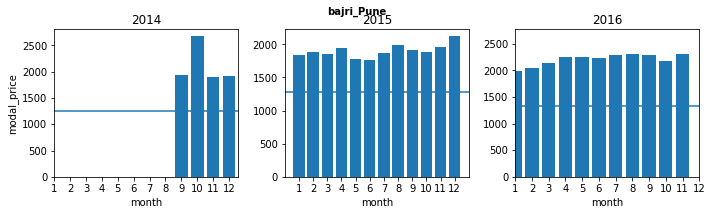

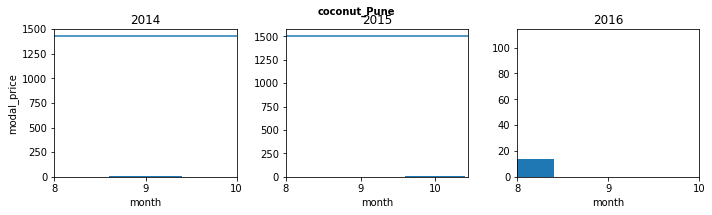

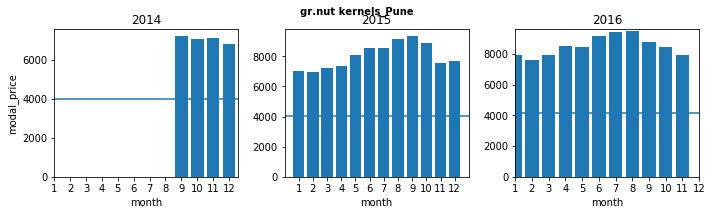

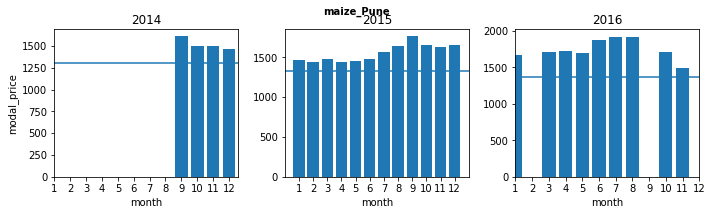

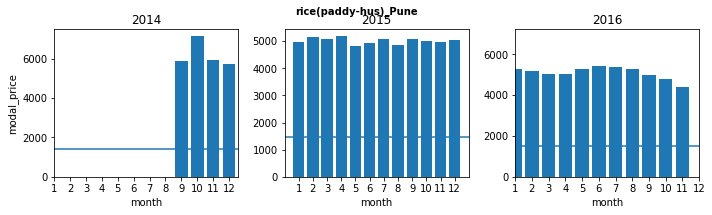

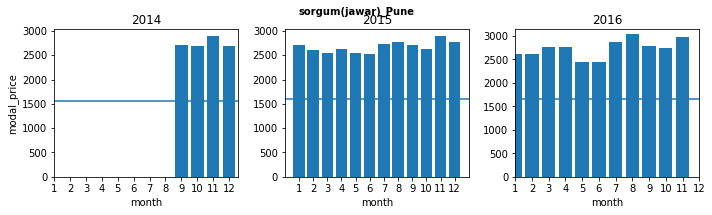

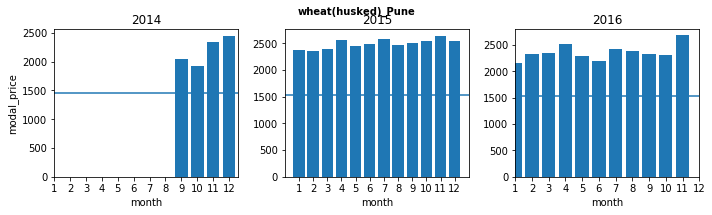

In [50]:
apmc_commodity = apmc_msp_data.apmc_comd.unique().tolist()
for e in apmc_commodity:
    apmc_comd = apmc_msp_data[(apmc_msp_data.apmc_comd == e)].sort_values(['monthnum'], ascending = False)
    apmc_comd_2014 = apmc_msp_data[(apmc_msp_data.apmc_comd == e) & (apmc_msp_data.year == 2014)].sort_values(['monthnum'], ascending = False)
    apmc_comd_2015 = apmc_msp_data[(apmc_msp_data.apmc_comd == e) & (apmc_msp_data.year == 2015)].sort_values(['monthnum'], ascending = False)
    apmc_comd_2016 = apmc_msp_data[(apmc_msp_data.apmc_comd == e) & (apmc_msp_data.year == 2016)].sort_values(['monthnum'], ascending = False)


    # Initialize the plot
    fig = plt.figure(figsize= (10,3))
    ax1 = fig.add_subplot(1,3,1)
    ax2 = fig.add_subplot(1,3,2)
    ax3 = fig.add_subplot(1,3,3)

    # Plot the data
    if not apmc_comd_2014.msprice.tolist():
        ax1.bar(apmc_comd_2014.monthnum.tolist(),apmc_comd_2014.modal_price)
        ax1.axhline(0)
    else:
        ax1.bar(apmc_comd_2014.monthnum.tolist(),apmc_comd_2014.modal_price)
        ax1.axhline(apmc_comd_2014.msprice.tolist()[0])
    if not apmc_comd_2015.msprice.tolist():
        ax2.bar(apmc_comd_2015.monthnum.tolist(),apmc_comd_2015.modal_price)
        ax1.axhline(0)
    else:
        ax2.bar(apmc_comd_2015.monthnum.tolist(),apmc_comd_2015.modal_price)
        ax2.axhline(apmc_comd_2015.msprice.tolist()[0])
    if not apmc_comd_2016.msprice.tolist():
        ax3.bar(apmc_comd_2016.monthnum.tolist(),apmc_comd_2016.modal_price)
        ax3.axhline(0)
    else:
        ax3.bar(apmc_comd_2016.monthnum.tolist(),apmc_comd_2016.modal_price)
        ax3.axhline(apmc_comd_2016.msprice.tolist()[0])

    #labelling and adjusting the subplots
    xleft , xright = (apmc_comd.monthnum.min(), apmc_comd.monthnum.max())
    ymax = apmc_comd.modal_price.max()+100
    xticks = [i for i in range(xleft, xright+1, 1)]
    ax1.set(title=2014, xlabel="month", ylabel="modal_price")
    ax1.xaxis.set(ticks = xticks)
    ax2.set(title=2015, xlabel="month" )
    ax2.xaxis.set(ticks = xticks)
    ax3.set(title=2016, xlabel="month" )
    ax3.xaxis.set(ticks = xticks)

    #showing the plot with tight layout
    fig.suptitle(e, fontsize = 10, fontweight='bold')
    plt.xlim(xleft, xright)
    plt.ylim(0, ymax)
    fig.subplots_adjust(top=0.9)
    plt.tight_layout()
    plt.show()

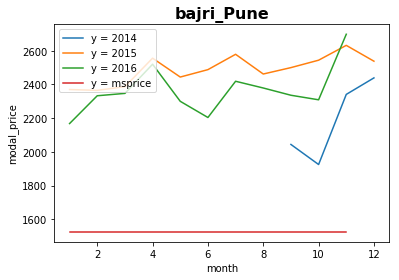

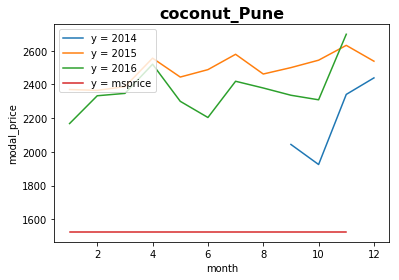

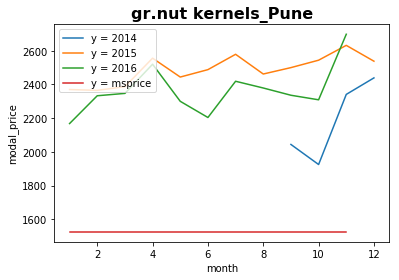

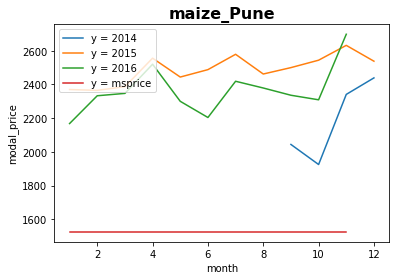

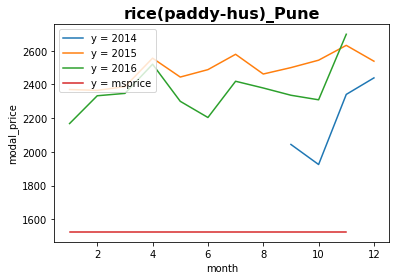

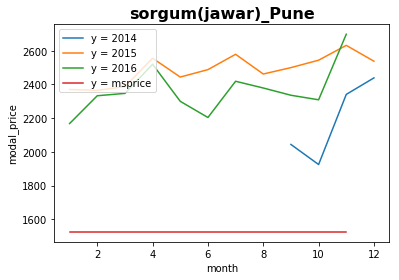

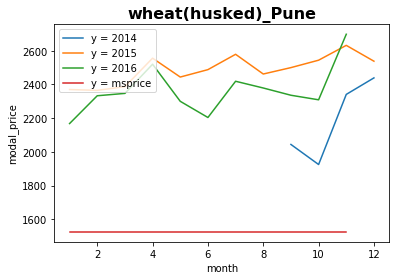

In [52]:
for e in apmc_commodity:
    fig = plt.figure()

    plt.plot(apmc_comd_2014.monthnum, apmc_comd_2014.modal_price)
    plt.plot(apmc_comd_2015.monthnum, apmc_comd_2015.modal_price)
    plt.plot(apmc_comd_2016.monthnum, apmc_comd_2016.modal_price)
    plt.plot(apmc_comd_2016.monthnum, apmc_comd_2016.msprice)

    plt.title(e, fontsize=16, fontweight='bold')

    plt.xlabel('month')
    plt.ylabel('modal_price')

    plt.legend([ 'y = 2014', 'y = 2015', 'y = 2016','y = msprice'], loc='upper left')
    #2014, 2015, 2016 lables provides modal_price and mspirce gives msprice of latest year